In [2]:
import pandas as pd
import os, re
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

sns.set_theme(style = "dark", 
        color_codes = True,
        font_scale = 1.5)

In [3]:
def load_partition_folder(partition="train"):
    partition_folder = os.path.join(os.getcwd(),'image_csv',partition)
    

    image_indexes,images,labels = [],[],[]

    for image_fname in os.listdir(partition_folder):
        image_re = re.match(r'([0-9]+)_([0-9]+)\.csv',image_fname)
        image_indexes.append(image_re.group(1))
        labels.append(image_re.group(2))
        images.append(np.loadtxt(os.path.join(partition_folder,image_fname),delimiter=',',dtype=np.float32))

    image_df = pd.DataFrame({'img_index':image_indexes,'image':images,'label':labels})

    image_df["img_index"] = image_df["img_index"].astype(int)
    image_df["label"] = image_df["label"].astype(int)

    return image_df.sort_values(by="img_index").reset_index(drop=True).drop(['img_index'],axis=1)

In [4]:
train_df = load_partition_folder()
train_df.head()

,image,label
0,"[[3.0, 3.0, 3.0, 4.0, 3.0, 3.0, 4.0, 4.0, 4.0,...",3
1,"[[2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0,...",0
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2
3,"[[1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0,...",1
4,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10618 entries, 0 to 10617
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   10618 non-null  object
 1   label   10618 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 124.6+ KB


In [5]:
test_df = load_partition_folder(partition='test')
test_df.head()

,image,label
0,"[[2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",0
1,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",0
2,"[[1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0,...",0
3,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",0
4,"[[1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",0


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1405 entries, 0 to 1404
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   1405 non-null   object
 1   label   1405 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 16.6+ KB


In [6]:
X_train = train_df['image']
y_train = train_df['label']

X_test = test_df['image']
y_test = test_df['label']

In [13]:
# Attempt (Base Model) - With Freeze and Unfreeze layer 
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import cv2




# Parameters
img_size = (240, 240)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
num_classes = 4




# Example: Convert DataFrame to numpy array
X_train = np.array(train_df['image'].tolist())
y_train = train_df['label'].values
X_test = np.array(test_df['image'].tolist())
y_test = test_df['label'].values




# Ensure images have 3 channels
X_train = np.array([cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) if img.shape[-1] != 3 else img for img in X_train])
X_test = np.array([cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) if img.shape[-1] != 3 else img for img in X_test])





# One-hot encode the labels
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)




# Load pre-trained EfficientNetB0 with a different input size
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=img_shape)




# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)  # Output layer for 4 classes




# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)




# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False




# Compile the model for multi-class classification
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Train the model
history = model.fit(X_train, y_train_encoded, epochs=5, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping])




# Unfreeze some layers and fine-tune
for layer in base_model.layers[-20:]:
    layer.trainable = True




# Recompile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])




# Continue training
history_fine = model.fit(X_train, y_train_encoded, epochs=5, validation_data=(X_test, y_test_encoded))




# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')



Epoch 1/5
332/332 [==============================] - 619s 2s/step - loss: 0.5785 - accuracy: 0.7629 - val_loss: 0.3615 - val_accuracy: 0.8683
Epoch 2/5
332/332 [==============================] - 622s 2s/step - loss: 0.3964 - accuracy: 0.8453 - val_loss: 0.3395 - val_accuracy: 0.8747
Epoch 3/5
332/332 [==============================] - 646s 2s/step - loss: 0.3410 - accuracy: 0.8697 - val_loss: 0.2592 - val_accuracy: 0.9011
Epoch 4/5
332/332 [==============================] - 642s 2s/step - loss: 0.2900 - accuracy: 0.8927 - val_loss: 0.2753 - val_accuracy: 0.8940
Epoch 5/5
332/332 [==============================] - 763s 2s/step - loss: 0.2622 - accuracy: 0.8980 - val_loss: 0.2372 - val_accuracy: 0.9210
Epoch 1/5
332/332 [==============================] - 866s 3s/step - loss: 0.3617 - accuracy: 0.8625 - val_loss: 0.1871 - val_accuracy: 0.9267
Epoch 2/5
332/332 [==============================] - 879s 3s/step - loss: 0.2076 - accuracy: 0.9217 - val_loss: 0.1443 - val_accuracy: 0.9445
Epoch 

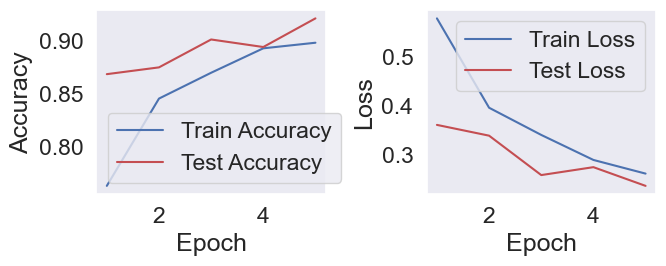

In [14]:
# For Base Model Attempt
import matplotlib.pyplot as plt
 
acc2 = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss2 = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1,len(acc2)+1)
 
# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
 
axes[0].plot(epochs, acc2,'b',label='Train Accuracy')
axes[0].plot(epochs, val_acc,'r',label='Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
 
axes[1].plot(epochs, loss2,'b',label='Train Loss')
axes[1].plot(epochs, val_loss,'r',label='Test Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
 
# Adjusting layout for better spacing
plt.tight_layout()
 
# Display the figure
plt.show()

In [8]:
# Attempt with Random Search (Benchmark to beat: 96.53%) Now: 91.53%
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import cv2
import keras_tuner as kt

# Parameters
img_size = (240, 240)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
num_classes = 4

# Example: Convert DataFrame to numpy array
X_train = np.array(train_df['image'].tolist())
y_train = train_df['label'].values
X_test = np.array(test_df['image'].tolist())
y_test = test_df['label'].values

# Ensure images have 3 channels
X_train = np.array([cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) if img.shape[-1] != 3 else img for img in X_train])
X_test = np.array([cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) if img.shape[-1] != 3 else img for img in X_test])

# One-hot encode the labels
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

# Define model builder function for Keras Tuner
def build_model(hp):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=img_shape)
    
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # Tune the number of units in the dense layer
    x = Dense(units=hp.Int('units', min_value=512, max_value=2048, step=256), activation='relu')(x)
    
    # Tune the dropout rate
    x = Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1))(x)
    
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Tune the learning rate for the optimizer
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Instantiate the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Specify the number of trials
    executions_per_trial=1,  # Specify how many models to build and fit for each trial
    directory='my_dir',
    project_name='efficientnet_tuning'
)

# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Perform hyperparameter tuning
tuner.search(X_train, y_train_encoded, epochs=5, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)

# Freeze the base model layers again for initial training
for layer in model.layers[:-3]:  # Assuming the last 3 layers are the custom layers
    layer.trainable = False

# Compile the model with the best hyperparameters
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, epochs=5, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping])

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')


Trial 27 Complete [00h 54m 25s]
val_accuracy: 0.8797153234481812

Best val_accuracy So Far: 0.9473309516906738
Total elapsed time: 15d 19h 45m 55s
Epoch 1/5
332/332 [==============================] - 673s 2s/step - loss: 0.5724 - accuracy: 0.7723 - val_loss: 0.4038 - val_accuracy: 0.8399
Epoch 2/5
332/332 [==============================] - 693s 2s/step - loss: 0.4223 - accuracy: 0.8371 - val_loss: 0.3672 - val_accuracy: 0.8612
Epoch 3/5
332/332 [==============================] - 645s 2s/step - loss: 0.3652 - accuracy: 0.8592 - val_loss: 0.2714 - val_accuracy: 0.9025
Epoch 4/5
332/332 [==============================] - 666s 2s/step - loss: 0.3357 - accuracy: 0.8752 - val_loss: 0.2336 - val_accuracy: 0.9132
Epoch 5/5
44/44 [==============================] - 73s 2s/step - loss: 0.2330 - accuracy: 0.9153
Test accuracy: 91.53%


In [7]:
# Attempt with Random Search 2 (Benchmark to beat: 96.53%) Now: 91.03% 
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import cv2
import keras_tuner as kt

# Parameters
img_size = (240, 240)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
num_classes = 4

# Example: Convert DataFrame to numpy array
X_train = np.array(train_df['image'].tolist())
y_train = train_df['label'].values
X_test = np.array(test_df['image'].tolist())
y_test = test_df['label'].values

# Ensure images have 3 channels
X_train = np.array([cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) if img.shape[-1] != 3 else img for img in X_train])
X_test = np.array([cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) if img.shape[-1] != 3 else img for img in X_test])

# One-hot encode the labels
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

# Define model builder function for Keras Tuner
def build_model(hp):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=img_shape)
    
    # Tune whether to train the base model layers
    freeze_layers = hp.Boolean('freeze_layers')
    for layer in base_model.layers:
        layer.trainable = not freeze_layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # Tune the number of units in the dense layer
    x = Dense(units=hp.Int('units', min_value=512, max_value=2048, step=256), activation='relu')(x)
    
    # Tune the dropout rate
    x = Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1))(x)
    
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Tune the learning rate for the optimizer
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Instantiate the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Specify the number of trials
    executions_per_trial=1,  # Specify how many models to build and fit for each trial
    directory='my_dir',
    project_name='efficientnet_tuning'
)

# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Perform hyperparameter tuning
tuner.search(X_train, y_train_encoded, epochs=10, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, epochs=5, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping])

# Unfreeze some layers for fine-tuning if the model was initially frozen
if best_hps.get('freeze_layers'):
    for layer in model.layers[-20:]:  # Fine-tuning the last 20 layers
        layer.trainable = True
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    history_fine = model.fit(X_train, y_train_encoded, epochs=5, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping])

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')


Reloading Tuner from my_dir\efficientnet_tuning\tuner0.json
Epoch 1/5
332/332 [==============================] - 2400s 7s/step - loss: 0.2823 - accuracy: 0.9034 - val_loss: 1.1844 - val_accuracy: 0.6911
Epoch 2/5
332/332 [==============================] - 2408s 7s/step - loss: 0.1236 - accuracy: 0.9609 - val_loss: 0.2386 - val_accuracy: 0.9103
Epoch 3/5
332/332 [==============================] - 2421s 7s/step - loss: 0.0848 - accuracy: 0.9724 - val_loss: 2.2346 - val_accuracy: 0.3829
Epoch 4/5
332/332 [==============================] - 2742s 8s/step - loss: 0.0672 - accuracy: 0.9782 - val_loss: 0.5246 - val_accuracy: 0.7922
Epoch 5/5
44/44 [==============================] - 67s 2s/step - loss: 0.2386 - accuracy: 0.9103
Test accuracy: 91.03%


In [8]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 512, 'max_value': 2048, 'step': 256, 'sampling': 'linear'}
dropout (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [11]:
callback = EarlyStopping(monitor='val_accuracy',patience=3)
tuner.search(X_train, y_train, epochs=15,batch_size=32, validation_data=(X_test, y_test), callbacks=[callback])

In [15]:
# For Attempt 5 
import numpy as np
predict_x = model.predict(X_test)
predict1 = np.argmax(predict_x, axis = 1)
print(predict1)

44/44 [==============================] - 71s 2s/step
[0 0 0 ... 3 3 3]


In [16]:
# For Attempt 5 
num_classes = 4
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_test, predict1, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.99      0.91      0.95       309
     Class 1       0.93      0.95      0.94       335
     Class 2       0.99      0.99      0.99       399
     Class 3       0.95      0.99      0.97       362

    accuracy                           0.96      1405
   macro avg       0.96      0.96      0.96      1405
weighted avg       0.96      0.96      0.96      1405



In [17]:
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 240, 240, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 240, 240, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 240, 240, 3)  0           ['normalization[0][0]']      

In [8]:
# Attempt (Without Freeze and Unfreeze) - Problem -> Infinite Loop

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import cv2
import kerastuner as kt

# Parameters
img_size = (240, 240)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
num_classes = 4

# Example: Convert DataFrame to numpy array
X_train = np.array(train_df['image'].tolist())
y_train = train_df['label'].values
X_test = np.array(test_df['image'].tolist())
y_test = test_df['label'].values

# Ensure images have 3 channels
X_train = np.array([cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) if img.shape[-1] != 3 else img for img in X_train])
X_test = np.array([cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) if img.shape[-1] != 3 else img for img in X_test])

# One-hot encode the labels
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

# Define model builder function for Keras Tuner
def build_model(hp):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=img_shape)
    
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # Tune the number of units in the dense layer
    x = Dense(units=hp.Int('units', min_value=512, max_value=2048, step=256), activation='relu')(x)
    
    # Tune the dropout rate
    x = Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1))(x)
    
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Tune the learning rate for the optimizer
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Instantiate the tuner
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=5,  # Set the maximum number of epochs to 5
                     factor=3,
                     directory='my_dir',
                     project_name='efficientnet_tuning')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Perform hyperparameter tuning
tuner.search(X_train, y_train_encoded, epochs=5, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train_encoded, epochs=5, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping])

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')


Trial 18 Complete [01h 06m 54s]
val_accuracy: 0.9387900233268738

Best val_accuracy So Far: 0.9387900233268738
Total elapsed time: 11d 02h 21m 11s

Search: Running Trial #19

Value             |Best Value So Far |Hyperparameter
1280              |1280              |units
0.4               |0.2               |dropout
0.001             |0.001             |learning_rate
4                 |10                |tuner/epochs
0                 |4                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/4
332/332 [==============================] - 676s 2s/step - loss: 0.6367 - accuracy: 0.7400 - val_loss: 0.3679 - val_accuracy: 0.8676
Epoch 2/4
231/332 [===================>..........] - ETA: 3:06 - loss: 0.4629 - accuracy: 0.8235

KeyboardInterrupt: 

In [9]:
# Attempt (Only Freeze) - Problem -> Infinite Loop

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import cv2
import keras_tuner as kt

# Parameters
img_size = (240, 240)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
num_classes = 4

# Example: Convert DataFrame to numpy array
X_train = np.array(train_df['image'].tolist())
y_train = train_df['label'].values
X_test = np.array(test_df['image'].tolist())
y_test = test_df['label'].values

# Ensure images have 3 channels
X_train = np.array([cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) if img.shape[-1] != 3 else img for img in X_train])
X_test = np.array([cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) if img.shape[-1] != 3 else img for img in X_test])

# One-hot encode the labels
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

# Define model builder function for Keras Tuner
def build_model(hp):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=img_shape)
    
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # Tune the number of units in the dense layer
    x = Dense(units=hp.Int('units', min_value=512, max_value=2048, step=256), activation='relu')(x)
    
    # Tune the dropout rate
    x = Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1))(x)
    
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Tune the learning rate for the optimizer
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Instantiate the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=5,  # Set the maximum number of epochs per trial
    factor=3,
    directory='my_dir',
    project_name='efficientnet_tuning'
)

# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Perform hyperparameter tuning
tuner.search(X_train, y_train_encoded, epochs=5, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)

# Freeze the base model layers again for initial training
for layer in model.layers[:-3]:  # Assuming the last 3 layers are the custom layers
    layer.trainable = False

# Compile the model with the best hyperparameters
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, epochs=5, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping])

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')


Trial 26 Complete [01h 04m 20s]
val_accuracy: 0.927402138710022

Best val_accuracy So Far: 0.9473309516906738
Total elapsed time: 13d 04h 39m 00s

Search: Running Trial #27

Value             |Best Value So Far |Hyperparameter
1536              |1024              |units
0.3               |0.2               |dropout
0.01              |0.001             |learning_rate
10                |10                |tuner/epochs
0                 |4                 |tuner/initial_epoch
0                 |1                 |tuner/bracket
0                 |1                 |tuner/round

Epoch 1/10
332/332 [==============================] - 662s 2s/step - loss: 0.8550 - accuracy: 0.7264 - val_loss: 0.4000 - val_accuracy: 0.8441
Epoch 2/10
332/332 [==============================] - 754s 2s/step - loss: 0.5997 - accuracy: 0.7609 - val_loss: 0.3904 - val_accuracy: 0.8569
Epoch 3/10
270/332 [=======================>......] - ETA: 1:46 - loss: 0.5531 - accuracy: 0.7874

KeyboardInterrupt: 

In [7]:
# Attempt (Only Unfreeze) - Problem -> Infinite Loop

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import cv2
import kerastuner as kt

# Parameters
img_size = (240, 240)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
num_classes = 4

# Example: Convert DataFrame to numpy array
X_train = np.array(train_df['image'].tolist())
y_train = train_df['label'].values
X_test = np.array(test_df['image'].tolist())
y_test = test_df['label'].values

# Ensure images have 3 channels
X_train = np.array([cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) if img.shape[-1] != 3 else img for img in X_train])
X_test = np.array([cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) if img.shape[-1] != 3 else img for img in X_test])

# One-hot encode the labels
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

# Define model builder function for Keras Tuner
def build_model(hp):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=img_shape)
    
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # Tune the number of units in the dense layer
    x = Dense(units=hp.Int('units', min_value=512, max_value=2048, step=256), activation='relu')(x)
    
    # Tune the dropout rate
    x = Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1))(x)
    
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Tune the learning rate for the optimizer
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Instantiate the tuner
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='efficientnet_tuning')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Perform hyperparameter tuning
tuner.search(X_train, y_train_encoded, epochs=10, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train_encoded, epochs=10, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping])

# Unfreeze some layers and fine-tune
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training
history_fine = model.fit(X_train, y_train_encoded, epochs=5, validation_data=(X_test, y_test_encoded))

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')


Trial 8 Complete [00h 23m 02s]
val_accuracy: 0.8604982495307922

Best val_accuracy So Far: 0.8939501643180847
Total elapsed time: 9d 22h 19m 05s

Search: Running Trial #9

Value             |Best Value So Far |Hyperparameter
768               |1280              |units
0.2               |0.3               |dropout
0.0001            |0.001             |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
117/332 [=========>....................] - ETA: 6:46 - loss: 0.8602 - accuracy: 0.6464

KeyboardInterrupt: 